# Small Example of iDLG on CIFAR10

In [1]:
from matplotlib import pyplot as plt 
import skimage 
import numpy as np 
from tqdm import tqdm
import torch as torch
import torch.nn as nn
from torchvision import transforms
from torch.optim.lbfgs import LBFGS
from torch.optim.adam import Adam
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from os import getcwd, listdir
from os.path import join

In [ ]:
import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.optim.lbfgs import LBFGS
from tqdm import tqdm


class iDLG:
    def __init__(
        self,
        model: nn.Module,
        orig_img: torch.Tensor,
        label: torch.Tensor,
        device,
        *,
        seed: int | None = None,
        clamp: tuple[float, float] | None = (0.0, 1.0),
    ) -> None:
        # Resolve device robustly
        if isinstance(device, str):
            self.device = torch.device(device)
        elif isinstance(device, torch.device):
            self.device = device
        else:
            # fallback: try attribute
            self.device = torch.device(getattr(device, "type", "cpu"))

        self.model = model.to(self.device)
        self.model.eval()

        self.orig_img = orig_img.to(self.device)
        self.label = label.to(self.device)

        # Ensure label shape/dtype is correct for CrossEntropyLoss
        # expects target shape [N] with dtype long
        if self.label.ndim == 0:
            self.label = self.label.view(1)
        self.label = self.label.long()

        self.criterion = nn.CrossEntropyLoss(reduction="sum").to(self.device)
        self.clamp = clamp

        # Match dummy dtype to model params dtype
        self.param_dtype = next(self.model.parameters()).dtype
        if self.orig_img.dtype != self.param_dtype:
            self.orig_img = self.orig_img.to(self.param_dtype)

        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    @staticmethod
    def _infer_label_from_grads(orig_grads: list[torch.Tensor], model: nn.Module) -> torch.Tensor:
        """
        iDLG label inference: argmin of the last bias gradient.
        Assumes there exists at least one 1D bias (common in classifiers).
        """
        named_grads = {name: g for (name, _), g in zip(model.named_parameters(), orig_grads)}

        last_bias_name = None
        for name, param in model.named_parameters():
            if name.endswith(".bias") and param.ndim == 1:
                last_bias_name = name

        if last_bias_name is None:
            raise ValueError("Could not find a 1D bias parameter (e.g., last layer bias) for label inference.")

        bias_grad = named_grads[last_bias_name]
        return torch.argmin(bias_grad).detach().view(1).long()

    def attack(
        self,
        iterations: int = 200,
        use_adam: bool = False,
        lr: float = 0.1,
        lbfgs_max_iter: int = 20,
    ):
        """
        Returns:
          recon_np: reconstructed image (H,W,C) or (C,H,W) depending on your squeeze; see note below
          label_pred: inferred label tensor shape [1]
          history: list of float numpy images (H,W,C) in [0,1]
          losses: list of scalar grad-matching objective values
        """
        # --- Compute original gradients once ---
        pred = self.model(self.orig_img)
        loss = self.criterion(pred, self.label)
        orig_grads = torch.autograd.grad(loss, self.model.parameters(), create_graph=False)
        orig_grads = [g.detach().clone() for g in orig_grads]

        # Infer label from gradients (iDLG trick)
        label_pred = self._infer_label_from_grads(orig_grads, self.model)

        # Dummy image: initialize INSIDE clamp range to avoid immediate clipping saturation
        dummy_data = torch.rand_like(self.orig_img, dtype=self.param_dtype, device=self.device, requires_grad=True)

        # Optimizer
        optimizer = LBFGS(
            [dummy_data],
            lr=lr,
            max_iter=lbfgs_max_iter,   # IMPORTANT: LBFGS does inner iterations itself
            history_size=100,
            line_search_fn="strong_wolfe",
            tolerance_grad=1e-9,
            tolerance_change=1e-11,
        )

        history: list = []
        losses: list[float] = []

        last_loss_value: float = float("nan")

        for _ in tqdm(range(iterations)):
            # Closure must: zero_grad -> compute objective -> backward -> return objective
            def closure():
                nonlocal last_loss_value
                optimizer.zero_grad(set_to_none=True)

                dummy_pred = self.model(dummy_data)
                dummy_loss = self.criterion(dummy_pred, label_pred)

                dummy_grads = torch.autograd.grad(
                    dummy_loss,
                    self.model.parameters(),
                    create_graph=True,   # needed to backprop into dummy_data
                )

                grad_diff = torch.zeros((), device=self.device, dtype=self.param_dtype)
                for gx, gy in zip(dummy_grads, orig_grads):
                    grad_diff = grad_diff + (gx - gy).pow(2).sum()

                grad_diff.backward()
                last_loss_value = float(grad_diff.detach().cpu().item())
                return grad_diff

            # LBFGS will call closure multiple times internally
            optimizer.step(closure)

            # Clamp AFTER the step (in-place, no reassignment)
            if self.clamp is not None:
                with torch.no_grad():
                    dummy_data.clamp_(self.clamp[0], self.clamp[1])

            # Log without calling closure again (no extra backward!)
            losses.append(last_loss_value)
            history.append(
                dummy_data[0].detach().cpu().clamp(0, 1).permute(1, 2, 0).numpy()
            )
        
        recon_np = dummy_data.detach().cpu().numpy().squeeze()
        return recon_np, label_pred, history, losses


### Define Model Architecture 

In [3]:
# 1 x (conv + activation) -> linear to num_classes
class LeNetSimple1sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.rand(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.rand(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple1Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple1Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.rand(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.rand(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [4]:
# 2 x (conv + activation) -> linear to num_classes
class LeNetSimple2sig(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2sig, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple2Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple2Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

In [5]:
# 3 x conv + activation -> linear to num_classes
class LeNetSimple3sig(nn.Module):
    def __init__(self, channel: int = 3, hidden:int = 768, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3sig, self).__init__()
        act = nn.Sigmoid
        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer2 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),)
        self.layer3 = nn.Sequential(nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),)
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(x)
        out = self.layer3(x)
        out = self.flatten(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10, input_shape=(1,3,32,32)):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
)
        flattened_size = self._get_flattened_size(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, num_classes)
)

    def _get_flattened_size(self, input_shape):
        with torch.no_grad():
            x = torch.randn(*input_shape)
            x = self.body(x)
            return x.view(x.size(0), -1).shape[1]

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)

model = LeNetSimple3sig()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
layer1 (Sequential) output shape:	 torch.Size([1, 12, 16, 16])
layer2 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
layer3 (Sequential) output shape:	 torch.Size([1, 12, 8, 8])
flatten (Flatten) output shape:	 torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [6]:
# 3 x conv + activation +  -> linear 768 to 10

# Sigmoid
class LeNet3sigAvg(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet3sigAvg, self).__init__()
        act = nn.Sigmoid
        pool = nn.AvgPool2d(kernel_size=5, padding=5//2, stride=1)
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            pool,
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            pool,
            act(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)
            if name == "body":
                print("Flattened shape:", X.view(X.size(0), -1).shape)
# Relu
class LeNetSimple3Relu(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNetSimple3Relu, self).__init__()
        act = nn.ReLU
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = LeNet3sigAvg()
model.layer_summary((1, 3, 32, 32))

Input shape: torch.Size([1, 3, 32, 32])
body (Sequential) output shape:	 torch.Size([1, 768])
Flattened shape: torch.Size([1, 768])
fc (Sequential) output shape:	 torch.Size([1, 10])


In [7]:
class LeNet(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)

class LeNet5(nn.Module):
    def __init__(self, channel: int = 3, num_classes: int = 10):
        super(LeNet5, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, 6, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
            nn.Sigmoid(),
        )

        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.flatten(x, 1)  # becomes (N, 120)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        print("Input shape:", X.shape)
        for name, layer in self.named_children():
            X = layer(X)
            print(f"{name} ({layer.__class__.__name__}) output shape:\t", X.shape)


### Initialize Model

In [8]:
from sklearn.model_selection import train_test_split
def get_images_from_folders(base_dir, label_folders, image_count):
    x = []
    y = []
    for label_idx, folder in enumerate(label_folders):
        folder_path = join(base_dir, folder)
        all_files = [f for f in listdir(folder_path) if f.endswith('.JPEG')]
        all_files.sort()
        selected_files = all_files[:image_count]
        x.extend([join(folder_path, fname) for fname in selected_files])
        y.extend([label_idx] * len(selected_files))
    return x, y

data_path = "/dtu/datasets1/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/"
label_folders = ["n01440764", "n01775062",  "n02086079",  "n02106030",  "n02190166",  "n02504013",  "n02906734",  "n03223299",  "n03627232",  "n03873416"]

# Example usage:
base_dir = data_path  # or set to your ImageNet subset root
image_count = 50  # number of images per class
x_all, y_all = get_images_from_folders(base_dir, label_folders, image_count)

# Split into train/test (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, stratify=y_all, random_state=42)

print(f"Train: {len(x_train)} images, Test: {len(x_test)} images")
print(f"First train image: {x_train[0]}, label: {y_train[0]}")

Train: 400 images, Test: 100 images
First train image: /dtu/datasets1/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n01775062/n01775062_1039.JPEG, label: 1


In [9]:
# Custom dataset for image paths and labels
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [10]:
# Define relevant variables for the ML task using custom ImageNet subset
batch_size = 1
num_classes = 10
learning_rate = 0.01
num_epochs = 10
modeltype = LeNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path = getcwd()

# Specify the desired image size (resolution)
img_size = (32, 32)  # (width, height)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
 ])

# Use x_train, y_train, x_test, y_test from previous cell
trainset = ImagePathDataset(x_train, y_train, transform=transform)
testset = ImagePathDataset(x_test, y_test, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

model = modeltype().to(device)
cost = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)

total_step = len(trainset)

save_dir = join(path, "reconstructions")
model.train()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 400 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                epoch+1, num_epochs, i+1, len(trainloader), loss.item()))
    if epoch == (num_epochs-1):
        torch.save(model.state_dict(), f"grads_{modeltype.__name__}_.pt")

Epoch [1/10], Step [400/400], Loss: 2.4340
Epoch [2/10], Step [400/400], Loss: 2.3149
Epoch [3/10], Step [400/400], Loss: 2.2971
Epoch [4/10], Step [400/400], Loss: 2.3456
Epoch [5/10], Step [400/400], Loss: 2.2584
Epoch [6/10], Step [400/400], Loss: 2.3657
Epoch [7/10], Step [400/400], Loss: 2.3256
Epoch [8/10], Step [400/400], Loss: 2.2773
Epoch [9/10], Step [400/400], Loss: 2.3429
Epoch [10/10], Step [400/400], Loss: 2.2982


In [11]:
model = LeNet(num_classes=10)
checkpoint = torch.load(f"grads_{modeltype.__name__}_.pt", map_location="cpu", weights_only=False)
print(type(checkpoint))
if isinstance(checkpoint, dict):
    print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

<class 'collections.OrderedDict'>
odict_keys(['body.0.weight', 'body.0.bias', 'body.2.weight', 'body.2.bias', 'body.4.weight', 'body.4.bias', 'fc.0.weight', 'fc.0.bias'])


LeNet(
  (body): Sequential(
    (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): Sigmoid()
    (2): Conv2d(12, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): Sigmoid()
    (4): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): Sigmoid()
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=10, bias=True)
  )
)

### Get a Datapoint 

In [12]:
# Load the first image from the first folder in your dataset
first_image_path = x_all[0]
img = Image.open(first_image_path).convert('RGB')
img_tensor = transform(img)  # transform returns a tensor of shape (C, H, W)
input_image = img_tensor.unsqueeze(0)  # Add batch dimension: (1, C, H, W)
label = torch.tensor([y_all[0]]).long()

### Attack 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 312.76it/s]


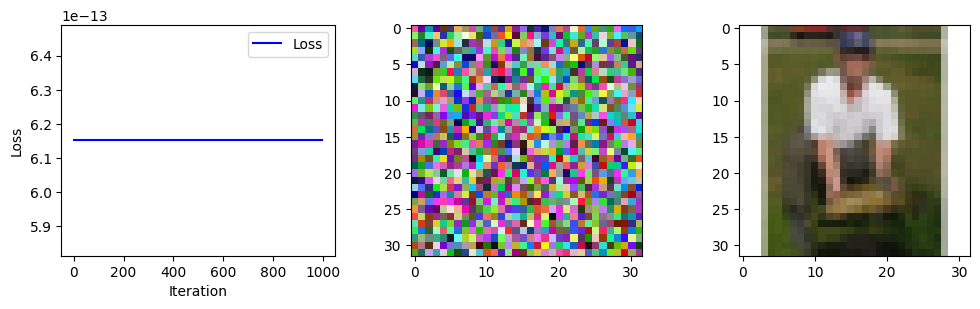

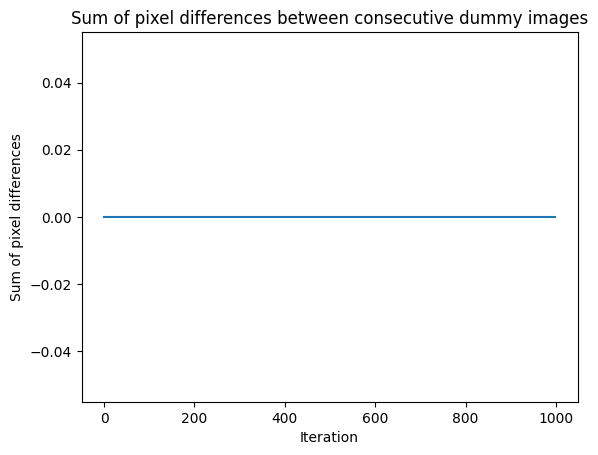

In [13]:
idlg = iDLG(model=model, device=torch.device("cpu"), orig_img = input_image, label = torch.tensor([label.item()]), clamp = (0, 1))
dummy_data_idlg, label_pred_idlg, history_idlg, losses_idlg = idlg.attack(iterations=1000)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].plot(losses_idlg, 'b-', label = 'Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].imshow(np.transpose(dummy_data_idlg, (1, 2, 0)))
# Show the original input image correctly
ax[2].imshow(np.transpose(input_image.squeeze().numpy(), (1, 2, 0)))
# ax[1].imshow(history_invgra[34])
plt.show()

diff = [np.abs(history_idlg[i+1] - history_idlg[i]).sum() for i in range(len(history_idlg)-1)]
plt.plot(diff)
plt.title('Sum of pixel differences between consecutive dummy images')
plt.xlabel('Iteration')
plt.ylabel('Sum of pixel differences')
plt.show()

100%|██████████| 1000/1000 [00:03<00:00, 313.36it/s]


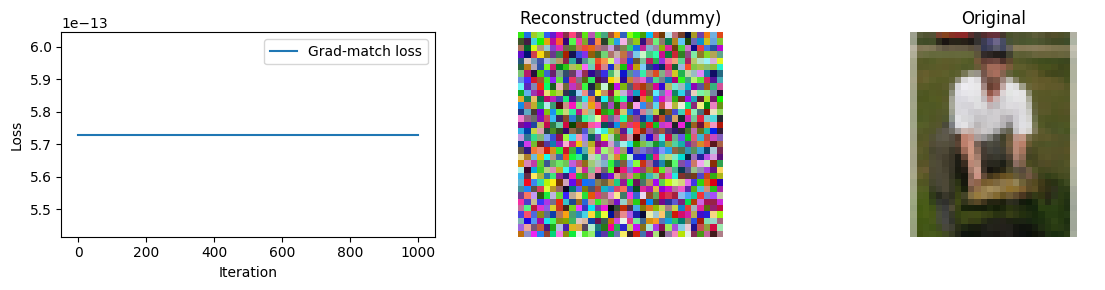

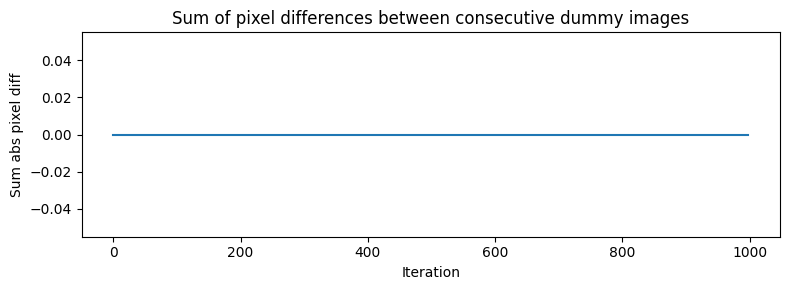

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Instantiate iDLG (label should already be shape [1] long; no need to re-wrap unless you must)
idlg = iDLG(
    model=model,
    device=torch.device("cpu"),
    orig_img=input_image,
    label=label,          # <-- use the original label tensor (expects [1] long)
    clamp=(0, 1),
)

dummy_data_idlg, label_pred_idlg, history_idlg, losses_idlg = idlg.attack(
    iterations=1000,
    use_adam=False,       # <-- LBFGS is the usual default for iDLG; set True if you really want Adam
)

# ---- Make arrays safe for plotting regardless of device/dtype ----
# dummy_data_idlg may come out as (C,H,W) or (H,W,C) depending on your return; handle both
dummy_np = np.array(dummy_data_idlg)

if dummy_np.ndim == 3 and dummy_np.shape[0] in (1, 3):          # (C,H,W)
    dummy_img = np.transpose(dummy_np, (1, 2, 0))
else:                                                           # already (H,W,C)
    dummy_img = dummy_np

orig_np = input_image.detach().cpu().squeeze().numpy()          # (C,H,W) if squeeze kept channels
if orig_np.ndim == 3 and orig_np.shape[0] in (1, 3):
    orig_img = np.transpose(orig_np, (1, 2, 0))
else:
    orig_img = orig_np

# ---- Plot loss + reconstruction + original ----
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].plot(losses_idlg, label="Grad-match loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].imshow(np.clip(dummy_img, 0, 1))
ax[1].set_title("Reconstructed (dummy)")
ax[1].axis("off")

ax[2].imshow(np.clip(orig_img, 0, 1))
ax[2].set_title("Original")
ax[2].axis("off")

plt.tight_layout()
plt.show()

# ---- Diff plot (history is already float HWC in [0,1] in the rewritten class) ----
diff = [np.abs(history_idlg[i + 1] - history_idlg[i]).sum() for i in range(len(history_idlg) - 1)]

plt.figure(figsize=(8, 3))
plt.plot(diff)
plt.title("Sum of pixel differences between consecutive dummy images")
plt.xlabel("Iteration")
plt.ylabel("Sum abs pixel diff")
plt.tight_layout()
plt.show()
